In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py
import sys
import os
import glob
import warnings
import pysindy as ps
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

warnings.filterwarnings('ignore')

# Closed Loop using a PCA mapping from myosin to flow

## Build a PCA translation model

In [2]:
from utils.dataset import *

transform=Reshape2DField()
pmg_cf_mask = np.load('Public/Masks/pmg_cf_mask.npy')

sqh_dataset = AtlasDataset('Halo_Hetero_Twist[ey53]_Hetero', 'Sqh-GFP', 'tensor2D', transform=transform, drop_time=True)
vel_dataset = AtlasDataset('Halo_Hetero_Twist[ey53]_Hetero', 'Sqh-GFP', 'velocity2D', transform=transform, drop_time=True)
#vel_dataset = AtlasDataset('WT', 'ECad-GFP', 'velocity2D', transform=transform)

100%|██████████| 6/6 [00:00<00:00, 303.31it/s]


Found SVDPipeline for this dataset!
Found SVDPipeline for this dataset!
0.8038727060988446


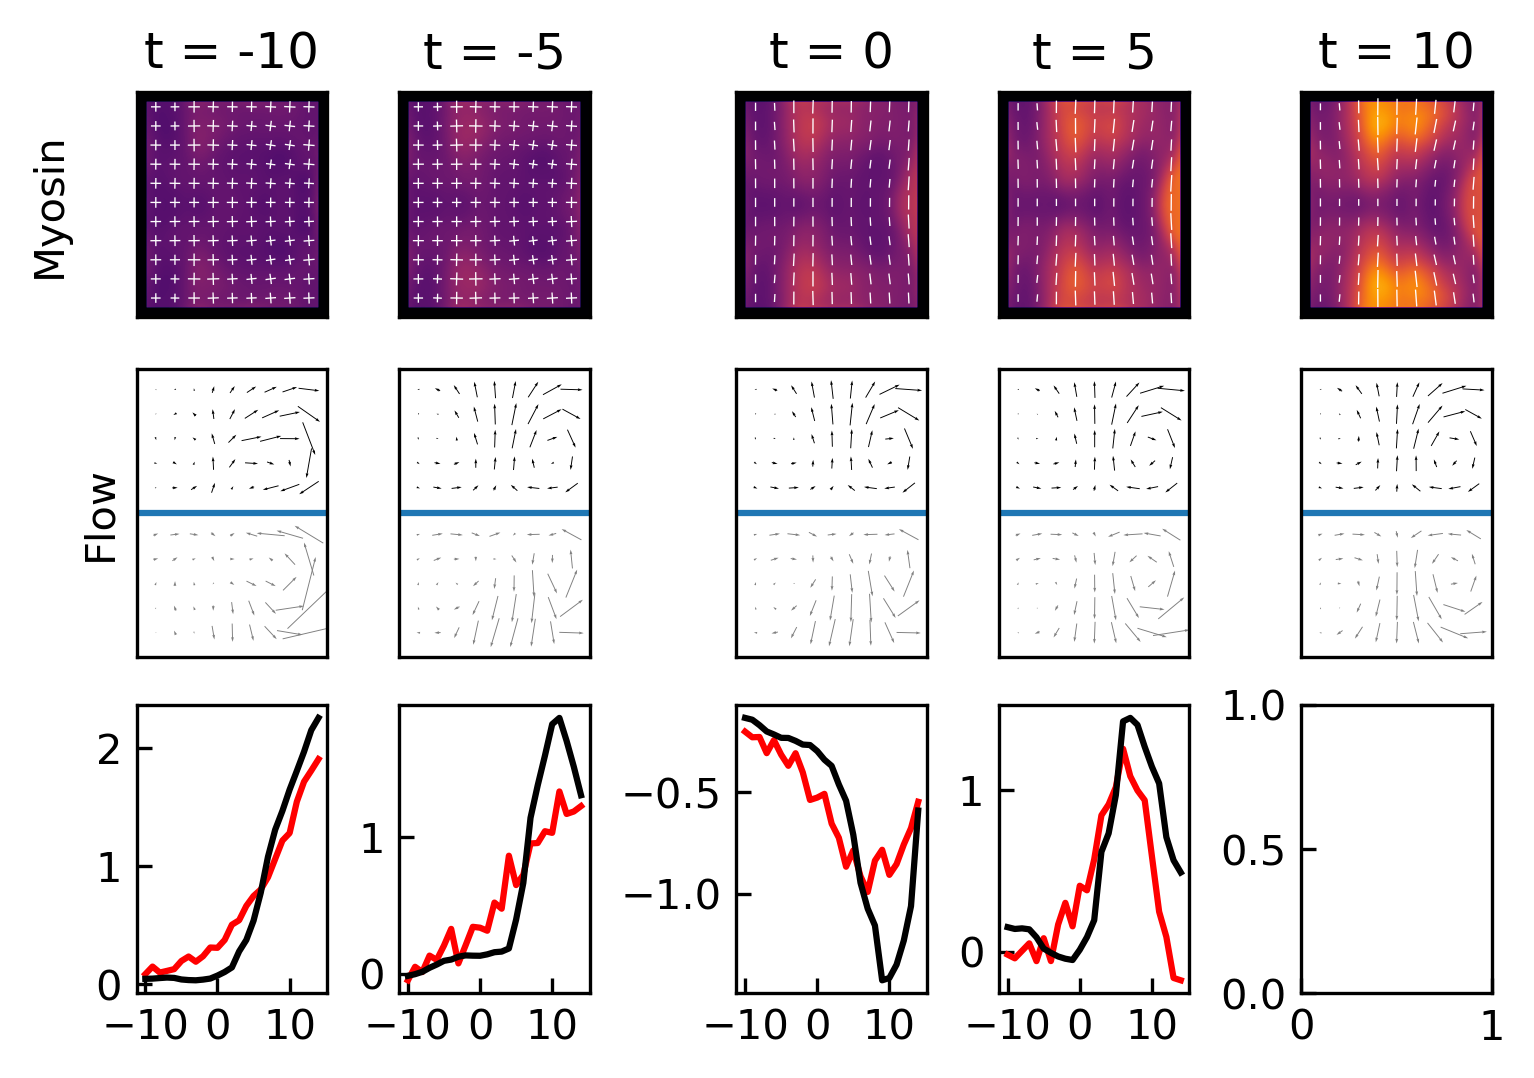

In [3]:
from utils.decomposition.decomposition_utils import get_decomposition_results
from utils.plot_utils import *
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge

def model_plot(m,
               v, v0,
               y, y0,
               t, dt=5):
    N = int(np.ceil(len(t) / dt))
    fig, ax = plt.subplots(3, N, figsize=(N, 3.5), dpi=300, constrained_layout=True)

    mnorm = np.linalg.norm(m0, axis=(1, 2))
    mmin = np.min(mnorm)
    mmax = np.max(mnorm)      
    
    mwargs = dict(cmap='inferno', vmin=mmin, vmax=mmax)
    
    vfc = 40
    apc = 10
    skip = 20
    ylim = [dv_min, dv_max]
    xlim = [ap_min, ap_max]
    
    slc = np.s_[..., ::skip, ::skip]
    X = np.linspace(ap_min, ap_max, m.shape[-1])
    Y = np.linspace(dv_min, dv_max, m.shape[-2])
    Y, X = np.meshgrid(Y, X, indexing='ij')
    
    top = np.s_[..., 118:, :]
    bot = np.s_[..., :118, :]
    vwargs = dict(pivot='middle', width=0.005)
    
    for i in range(N):
        ii = dt * i
        ax[0, i].set_title('t = %d' % (t[ii]))
    
        mwargs['both'] = t[ii] < 0
        plot_tensor2D(ax[0, i], m[ii], **mwargs)
        
        ax[1, i].quiver(X[bot][slc], Y[bot][slc], 
                        v0[ii, 1][bot][slc], v0[ii, 0][bot][slc],
                        color='grey', **vwargs)
        ax[1, i].quiver(X[top][slc], Y[top][slc], 
                        v[ii, 1][top][slc], v[ii, 0][top][slc],
                        color='black', **vwargs)
        ax[1, i].axhline(dv_min+(dv_max-dv_min)/2.)
        ax[1, i].set(xticks=[], yticks=[])
        
        if i < y.shape[-1]:
            ax[2, i].plot(t, y[:, i], color='red')
            ax[2, i].plot(t, y0[:, i], color='black')
        
    for a in ax[:2, :].flatten():
        a.set(xlim=xlim, ylim=ylim)

    lp=16
    ax[0, 0].set_ylabel('Myosin', labelpad=lp)
    ax[1, 0].set_ylabel('Flow')

def process(df, tmin=-10, tmax=15):
    df = df[(df.time >= tmin) & (df.time <= tmax)].reset_index(drop=True)
    df = df.drop(['index', 'set', 'Unnamed: 0', 'eIdx', 't', 'res', 'mag'], axis=1)
    df = df.sort_values(['embryoID', 'time'])
    #df = df.drop(['embryoID'], axis=1)
    #df = df.groupby(['time']).agg(np.mean).reset_index()
    return df

def getparams(df, kmax):
    keep = np.zeros(16, dtype=bool)
    keep[:kmax] = True
    return df.filter(like='param').values, keep

sqh_model, sqh_df = get_decomposition_results(sqh_dataset)
#    model_name='SVDPipeline_PMG_CF', mask=pmg_cf_mask)
vel_model, vel_df = get_decomposition_results(vel_dataset)
sqh_df = process(sqh_df)
vel_df = process(vel_df)

X, X_keep = getparams(sqh_df, 10)
y0, y_keep = getparams(vel_df, 4)
#X_keep[2] = 0

transformer = Ridge(alpha=1e-1)
transformer.fit(X[:, X_keep], y0[:, y_keep])
print(transformer.score(X[:, X_keep], y0[:, y_keep]))

def transform(m):
    X = sqh_model.transform(m)[:, X_keep]
    y = transformer.predict(X)
    v = vel_model.inverse_transform(y, y_keep)
    return v, y

n0, n1 = 15, 40
n0, n1 = 41, 66
n0, n1 = 67, 92
v0 = vel_model.inverse_transform(y0[n0:n1], y_keep)
m0 = sqh_model.inverse_transform(X[n0:n1], X_keep).reshape([-1, 2, 2, 236, 200])
v, y = transform(m0)

model_plot(m0, v, v0, y, y0[n0:n1], 
           sqh_df.time[n0:n1].values, dt=5)

## Integrate!

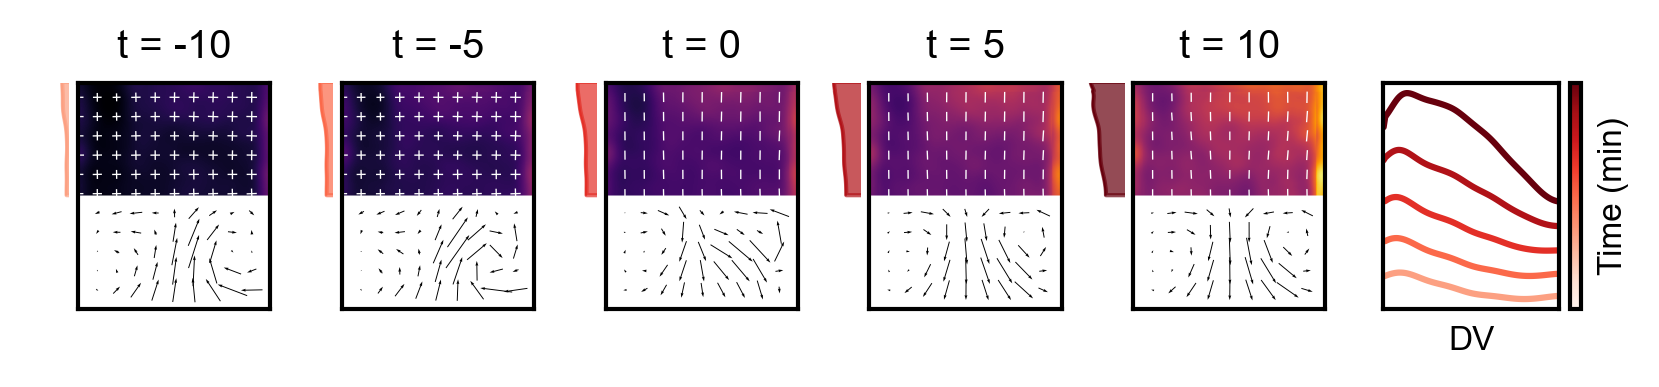

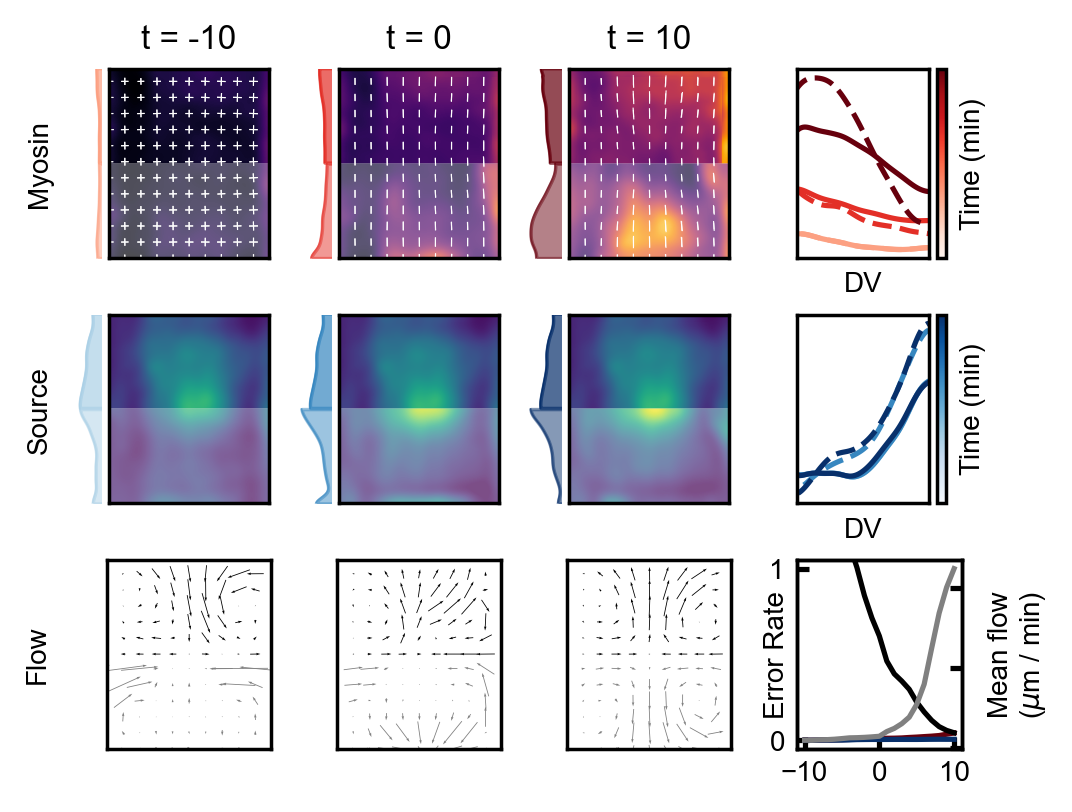

In [6]:
from utils.forecasting.closed_loop import ClosedFlyLoop
from utils.forecasting.plot_utils import *

'''
Collect initial conditions - m, c, v, gamma_d, gamma_dv, and time
'''
with h5py.File('Public/myosin_dynamics_fitting.h5', 'r') as h5f:
    data = h5f['ensemble']
    tmin = -10
    tmax = 10
    
    t = data['fields/v'].attrs['t']
    t_mask = np.logical_and(t >= tmin, t <= tmax)
    
    m0 = data['fields/m_ij'][t_mask, ...][()]
    s0 = data['fields/c'][t_mask, ...][()]    
    v0 = data['fields/v'][t_mask, ...][()]
    t0 = t[t_mask, ...][()]
    
v_model = lambda t, y: transform(y.reshape([-1, *y.shape[-3:]]))[0]

model = ClosedFlyLoop(v_model, 
                      v_thresh=0.,
                      sigma=(7, 5))

y0 = np.concatenate([
    m0[0].reshape([4, *m0.shape[-2:]]),
    s0[0].reshape([1, *s0.shape[-2:]]),
])    
model.fit(y0[None])
m, s, v = model.integrate(y0, t0)

sqh_vel_plot(m, v, t0, dt=5)
comparison_plot(t0,
                ('Myosin', m, m0),
                ('Source', s, s0),
                ('Flow', v, v0),
                dt=10)